  



## RNN for time-series 5' imputation prediction using hourly past data

We will start importing all the packages we need.
We will use:
- numpy for mathematical computations
- pandas for Datasets
- matplotlib for plotting
- tennsforflow (with keras) for the Neural Networks

From tensforflow.keras we will later use:

- from keras.models import Sequential -> to construct the RNN
- from keras.layers import Dense -> layers is to add LSTM and normal components to the network
- from keras.layers import LSTM
- from keras.optimizers import RMSprop -> our chosen optimizer for training

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


We first load the data from the excel field and we convert it into DataFrame format.
We will also create more columns to better understand the problem we are facing.

The first columns will be called Close, and it will refer to the 5 minutes data.
The second column will be created from the first column, but just using the hourly data.
Finally, we will create a Missing values column, where only the missing values will be given.  

In [75]:
data_5 = pd.read_excel('FCA.xlsx')
data_1h = pd.read_excel('FCA2.xlsx')
data_5.rename(columns={'Close(FCHA.MI)':'Close',}, inplace=True)#change name of columns
data_1h.rename(columns={'Close(FCHA.MI)':'Close',}, inplace=True)
train_hour = data_5[::12]#data each hour 12*5=60
data_5['Hourly'] = train_hour['Close'] #add this column to the dataframe
#Close column -> desired and known output
#Hourly column -> known input
data_5 = data_5.assign(Missing= np.nan)#add a column 
data_5.Missing[data_5.Hourly.isna()] = data_5.Close#contaons the missing values only

print(len(data_5))
data_5.head(10)

2011


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,Close,Hourly,Missing
0,2020-03-02 11:15:00,10.814,10.814,NaN
1,2020-03-02 11:10:00,10.842,NaN,10.842
2,2020-03-02 11:05:00,10.862,NaN,10.862
3,2020-03-02 11:00:00,10.890,NaN,10.890
4,2020-03-02 10:55:00,10.886,NaN,10.886
5,2020-03-02 10:50:00,10.918,NaN,10.918
6,2020-03-02 10:45:00,10.936,NaN,10.936
7,2020-03-02 10:40:00,10.960,NaN,10.960
8,2020-03-02 10:35:00,10.970,NaN,10.970
9,2020-03-02 10:30:00,11.012,NaN,11.012


Before starting with the computation, we will have a look at the graphs of the prices.

We will first plot the prices independently to see the effect that GRANULARITY has on the visualization of the time-series. 

On the second plot, we will show a comparison between the given data(hourly prices) and the missing data that we will try to predict with the first one.
For visualization reasons, we will just plot the first 200 values in this case.


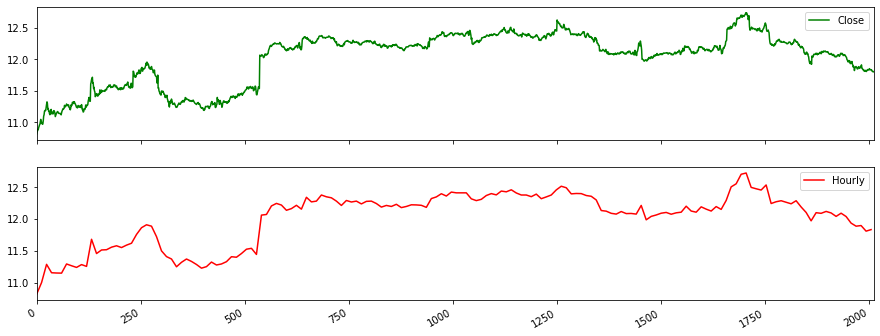

In [3]:

data_5[['Close', 'Hourly']].plot(subplots=True, color=['green','red'],figsize=(15, 6))
plt.plot(data_5['Hourly'][::12],'r-')

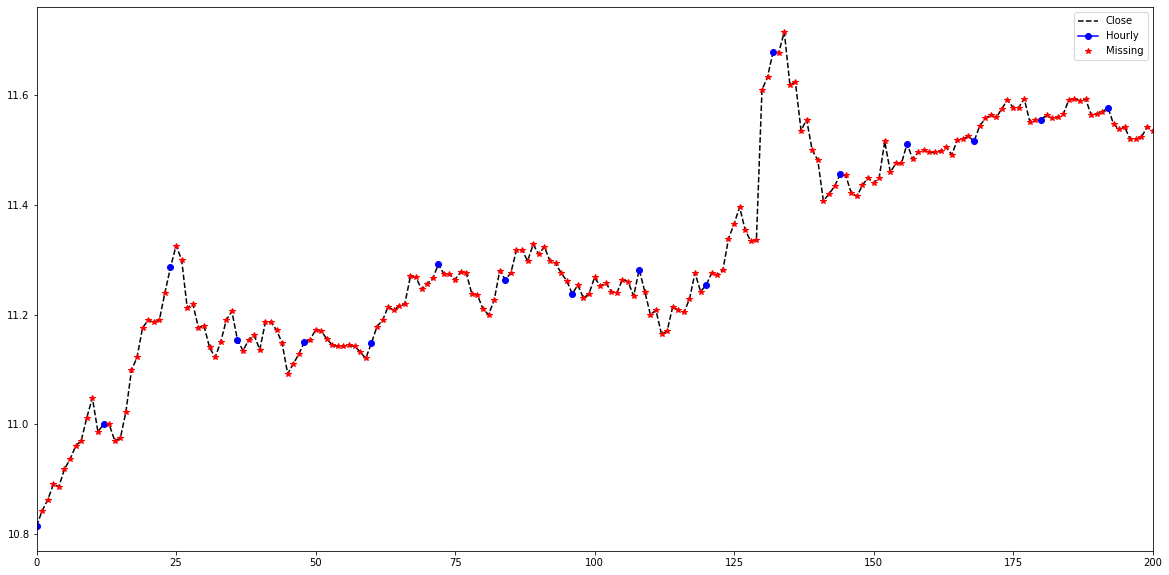

In [4]:
data_5.loc[:200,['Close','Hourly','Missing']].plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

To predict the Missing values(red points on the graph) with the Hourly prices(blue points on the graph),
we will present several approaches.
We will first show a classical representation on how to solve the problem using the mean, mode, and interpolation methods.

After that, we will present the solution using Neural Networks, in particular using Recurrent Neural Networks.
To do so, we will use a window of the prices for the last 7 hours to fill the next hour with the 5 minutes prices.


### Interpolation methods:

##### Impute using the mean/meadian/mode

We can observe that the Hourly prices missing values will be filled with the mode/median or mean using the values of the previous and preceding hour.


In [5]:
data_mean = pd.DataFrame
data_mean = data_5.copy()
l = []
for i in range(len(data_mean)-12):    
     if np.isnan(data_mean['Hourly'][i]) == False:
            mean_comp = [data_mean['Hourly'][i],data_mean['Hourly'][i+12]]
            x = np.array(mean_comp).mean()# or .median() or mode()
            for y in range(12):
                l.append(x)
            
for k in range(len(data_mean)-6):
 
        if np.isnan(data_mean['Hourly'][k]) == True:
            data_mean['Hourly'][k] = l[k]

data_mean.head(7)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Close,Hourly,Missing
0,2020-03-02 11:15:00,10.814,10.814,NaN
1,2020-03-02 11:10:00,10.842,10.907,10.842
2,2020-03-02 11:05:00,10.862,10.907,10.862
3,2020-03-02 11:00:00,10.890,10.907,10.890
4,2020-03-02 10:55:00,10.886,10.907,10.886
5,2020-03-02 10:50:00,10.918,10.907,10.918
6,2020-03-02 10:45:00,10.936,10.907,10.936


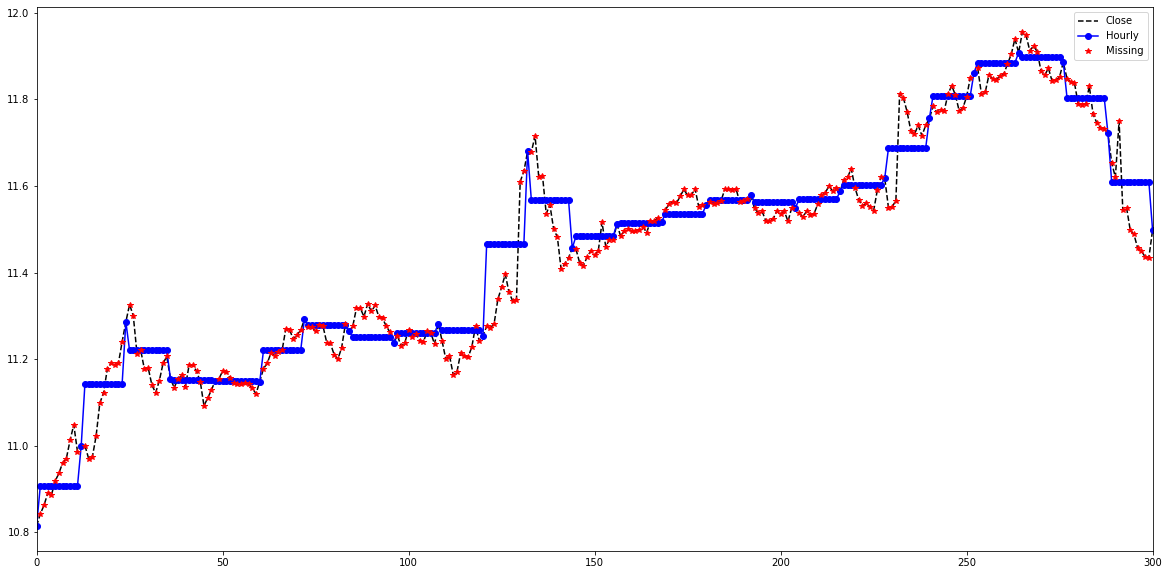

In [6]:
data_mean.loc[:300,['Close','Hourly','Missing']].plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

#### Impute using interpolations (linear/ quadratic/ polinomial)



In [7]:

df = pd.DataFrame
df = data_5.copy()
df = df.assign(InterpolateQuadratic=df.Hourly.interpolate(method='quadratic')) #or linear or polinomila
df.head(10)

,Date,Close,Hourly,Missing,InterpolateQuadratic
0,2020-03-02 11:15:00,10.814,10.814,NaN,10.814000
1,2020-03-02 11:10:00,10.842,NaN,10.842,10.821641
2,2020-03-02 11:05:00,10.862,NaN,10.862,10.830711
3,2020-03-02 11:00:00,10.890,NaN,10.890,10.841210
4,2020-03-02 10:55:00,10.886,NaN,10.886,10.853138
5,2020-03-02 10:50:00,10.918,NaN,10.918,10.866494
6,2020-03-02 10:45:00,10.936,NaN,10.936,10.881280
7,2020-03-02 10:40:00,10.960,NaN,10.960,10.897494
8,2020-03-02 10:35:00,10.970,NaN,10.970,10.915138
9,2020-03-02 10:30:00,11.012,NaN,11.012,10.934210


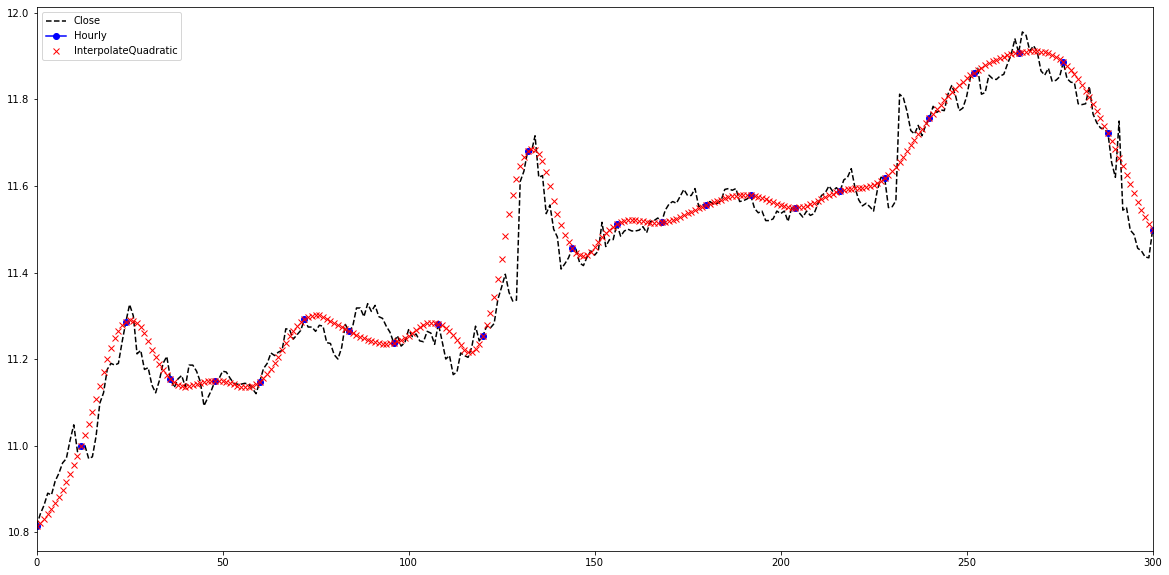

In [8]:
df.loc[:300,['Close','Hourly','InterpolateQuadratic']].plot(style=['k--', 'bo-', 'rx'], figsize=(20, 10))

### Prediciton of multi-steps


Given a past set of values, the model will learn how to predict the next values. 
However, it is important to differentiate this problem from a classical forecasting price example.
We can define 2 main differences.
 1. The number of values in the future we want to predict. We are not only interested in forecasting the next value but the next 11 -> data one hour sampled every 5 minutes.
 
 2. The sampling of the data we will use for the forecasting doesn't have the same length. In other words, the data is given each hour while we want to predict jumps of 5 minutes. 


From now on, we will exemplify this problem with a simple example where using the data from the last 7 hours we will predict the 5 minutes data for the next hour, of the next day. 



In [9]:
features_considered = ['Close','Hourly']# we just need the prices column
features = data_5[features_considered]
#features.index = data_5['Date'] #we can put Date as index 


Last day data: 7 hours prices --> we need a past history window of 7 values of the hourly feature.

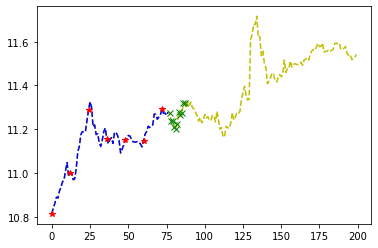

In [10]:
plt.plot(features['Close'][:200],'y--')#all prices 
plt.plot(features['Close'][:200][:77], 'b--')#prices for the last 7 HOURS
plt.plot(features['Close'][:200][::12][:7], 'r*')#hourly prices from the last 7 hours
plt.plot(features['Close'][:200][77:77+11], 'gx')#5 minutes prices for the next hour

##### Preprocessing

In [11]:
FCA = pd.read_excel("FCA.xlsx")
FCA.Date = pd.to_datetime(FCA.Date, format= "%d/%m/%Y  %H:%M:%S") #rewrite date column with this format
# Rows of interest

df = FCA.loc[(FCA.Date.dt.hour>=10)&(FCA.Date.dt.hour<17)&(FCA.Date>="2020-02-04")&(FCA.Date<="2020-03-01")].loc[(FCA.Date.dt.day!=24)&(FCA.Date.dt.day!=26)].sort_values(by="Date", ascending=True).reset_index(drop=True).rename({"Close(FCHA.MI)":"Price"}, axis='columns')


We first split the data into train and testing.

From 112 windows we will use 80% for training and 20% for validation. We will use 89 groups for testing and 23 for validation.
We also need to define the seed to initialize the number generator.

In [12]:
TRAIN_SPLIT = int(112*0.80)
tf.random.set_seed(3)

In [13]:
df_h = df.loc[df.Date.dt.minute==0].copy() #hours (when the minutes equivalent to 0)
df_m = df.loc[df.Date.dt.minute!=0].copy() #minutes (when the minutes different from 0)

We need to normalize the dataset.
In this case, we will use standardization, therefore we need to compute the mean of the values and divide them with the standard deviation. 
We will just perform the normalization for the training set.

In [14]:
df = features.values
data_mean = df[:TRAIN_SPLIT].mean(axis=0)
data_std = df[:TRAIN_SPLIT].std(axis=0)
df = (df-data_mean)/data_std

In [15]:
df_h.shape #119 rows and 2 columns(dates and prices)

(119, 2)

In [16]:
df_m.shape

(1309, 2)

In [17]:
X, Y = np.empty((df_h.shape[0]-7, 7)), np.zeros((int(df_m.shape[0]/11)-7, 11)) 
#create an empty matrix with the requested dimensions 
#df_h for x 7 feautures, 7 hours, 
#total nr of observations minus 7 windows, 
#we can't ask/predict the first 7 hours(first day),
#because we don't have the n-1 day, 
#112 (because 119-7) groups of 7 hours, 
#dimensions 112,7
#df_m for y , dimensions 112,11 , 11 5mins of the first hour of the first day, 10h of day 1

for row, i in enumerate(range(7,df_h.shape[0])): #loop from 7 to 112 #rolling window 
    X[row,:] = df_h.iloc[(i-7):i,1].values
for row, i in enumerate([(i,j) for i in sorted(set(df_m.Date.dt.day))[1:] for j in sorted(set(df_m.Date.dt.hour))]): 
    Y[row,:] = df_m.loc[(df_m.Date.dt.day==i[0])&(df_m.Date.dt.hour==i[1]),"Price"].values
    

In [18]:
X.shape

(112, 7)

In [19]:
Y.shape

(112, 11)

In [20]:
X[:1], Y[:1] 
#assumes we start at day 0 
#we are interested in the first hour of day 1, 
#so we give the model the prices of the 7 previous hours 
#from day zero and the models gives the prices in 
#5mins jumps of the first hour of day 1 
#first line we can see the 7 prices from the 7 previous hours 
#second line we the 11 prices of the 5 mins

(array([[11.96 , 12.072, 12.048, 12.044, 12.08 , 12.124, 12.092]]),
 array([[12.114, 12.102, 12.08 , 12.092, 12.084, 12.102, 12.106, 12.16 ,
         12.178, 12.18 , 12.196]]))

In [21]:
print(X[:3]) #rolling effect on the matrix, check the X[:4]

[[11.96  12.072 12.048 12.044 12.08  12.124 12.092]
 [12.072 12.048 12.044 12.08  12.124 12.092 12.11 ]
 [12.048 12.044 12.08  12.124 12.092 12.11  12.188]]


In [22]:
print(Y[:3]) #each line is an hour, each columns advances from 5 to 5 

[[12.114 12.102 12.08  12.092 12.084 12.102 12.106 12.16  12.178 12.18
  12.196]
 [12.206 12.188 12.182 12.198 12.202 12.22  12.238 12.224 12.234 12.262
  12.276]
 [12.27  12.286 12.286 12.298 12.31  12.318 12.3   12.262 12.266 12.26
  12.24 ]]


In [23]:
df_h.shape[0] + df_m.shape[0]

1428

First, we introduce some terminology:

History size -> size of the past window of information -> number of values considered.

Target size -> how far in the future does the model need to learn to predict. Values that need to be predicted (labels).

Number of steps -> jumps of our window, we jump from one value to the next one when we shift the values.

One epoch -> one forward pass and one backward pass of ALL the training examples-

Batch size -> Number of training examples cut the prices in semi-redundant sequences of maxlen characters.

Number of iterations -> number of passes. In each pass, we use the batch_size(with length the number of examples).

Buffer -> To be reshaped into a tensor form : [batch_size, number_steps, number_features]

In our simple example we will consider:
- Batch size = 30
-  Number steps = 1
-  Number features = 1 (Just close price)
-  Histort size = 7 -> 7 last hours of the previous day
-  Target size = 11 -> the 5 minutes prices for the next hour





In [24]:

BATCH_SIZE = 120
BUFFER_SIZE =1000 #-> to be reshaped [batch_size, number_steps, number_features]

In [25]:
X[:TRAIN_SPLIT].shape

(89, 7)

In [26]:
x_train = np.reshape(X[:TRAIN_SPLIT], (TRAIN_SPLIT,7,1))
y_train = np.reshape(Y[:TRAIN_SPLIT], (TRAIN_SPLIT,11,1))

x_val = np.reshape(X[TRAIN_SPLIT:], (112-TRAIN_SPLIT,7,1))
y_val = np.reshape(Y[TRAIN_SPLIT:], (112-TRAIN_SPLIT,11,1))

In [27]:
print ('Window of past history : {}'.format(x_train.shape))
print ('\n Target prices to predict : {}'.format(y_train.shape))

Window of past history : (89, 7, 1)

 Target prices to predict : (89, 11, 1)


In [30]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#we create a dataset (in form of a tensor) from the lists
train_data

<TensorSliceDataset shapes: ((7, 1), (11, 1)), types: (tf.float64, tf.float64)>

In [31]:

train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# cache()-> Caches the elements in this dataset.
#The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. 
#Subsequent iterations will use the cached data
#shuffle -> Randomly shuffles the elements of this dataset.

"""10,000 elements but buffer_size is set to 1,000, 
then shuffle will initially select a random element from only the
first 1,000 elements in the buffer. Once an element is selected, 
its space in the buffer is replaced by the next (i.e. 1,001-st) 
element,
maintaining the 1,000 element buffer."""

train_data


#batch(batch_size) -> Combines consecutive elements of this dataset into batches.it creates groups od the size = batch size
#repeat() -> Repeats this dataset so each original value is seen count times.

<RepeatDataset shapes: ((None, 7, 1), (None, 11, 1)), types: (tf.float64, tf.float64)>

In [32]:

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [33]:
val_data

<RepeatDataset shapes: ((None, 7, 1), (None, 11, 1)), types: (tf.float64, tf.float64)>


We are working on a univariate series, therefore the number of features is one.

The number of time steps(input), is the number that will split the sequence. 
The input shape is the shape of the input for each sample.
We just have to define the input shape in the first layer.
For each sample, the model expects time steps and some features. In our example, the input shape is (112,7). This means that for each sample we will have 112 values and 7 features.
The total number of samples is 1428. This number includes all the vectors of size 112 that role from one value to the other by removing the first value and adding the next one. This refers to the previous step where we split the sequence into samples. 

We will use LSTM for our Neural Network model because it can output a vector and not a single value, which in practice means that we can forecast more than one step.
However, LSTM expects data to have 3 dimensions [samples, time steps, features]. In our case, the reshape is easy because the time-step is 1.



We will use 3 layers :
- Input layer:
    - Layer type: LSTM
    - Neurons:  32 neurons
    - Activation functions that are contained in a LSTM (3 sigmoids and one hyperbolic tangent)

- Hidden Layer:
    - Layer type: LSTM. To perform regression with a recurrent neural network (RNN), typically a dense layer is added taking the RNN hidden state as input. As a result, the traditional LSTM with tanh followed by a dense layer works.
    - Neurons:  16 nodes in the next layer. So, we expect to reduce the number of neurons 1/2 from the previous LSTM.   
    - Activation function: We will use ReLU because it is faster, performs well in hidden layers, and prevents the problem of the vanishing gradient which will make all extreme values have similar output. It is also quite recommended for its efficiency and low computation cost. Apart from the 'ReLU', the LSTM will also include the 3 sigmoids and one hyperbolic tangent that characterizes its nature.

- Output layer: 
    - Layer Type: We use a Dense layer as an output layer because it performs a matrix-vector multiplication. The values in the matrix are the trainable parameters that will update during backpropagation. You get an m dimensional vector as output. It is used to change the dimensions of the output vector.
    - Neurons: We define that the layer will have 11 nodes because it predicts 11 numerical values. 
    - Activation function: Purelin function because is the output layer and it gives the most exact and accurate prediction.


The model is fitted with the RMSprop Optimizer. We also tried Adam but RMSprop presented better results.

To compute the error we will use the mse -> mean square error as the loss function. We selected this loss function after trying both mse and mae(mean-absolute-error). However, mse outperformed mae.



In [51]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense((11)))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')

### Train data

We fit the model with 10 epochs.


In [52]:
EPOCHS =10
EVALUATION_INTERVAL = 200

multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 6s 30ms/step - loss: 46.1363 - val_loss: 1.2513
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1280 - val_loss: 1.5513
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1083 - val_loss: 1.1897
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0970 - val_loss: 1.4377
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0900 - val_loss: 0.9778
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0848 - val_loss: 1.3230
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0795 - val_loss: 1.0708
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0763 - val_loss: 0.9382
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0729 - val_loss: 0.6070
Epoch 10/10
200/200 [==========================

We can see how loss goes down as the accuracy increases

### Test results

In [53]:
for x, y in val_data.take(1):
    print (multi_step_model.predict(x)[0])

[12.1640005 12.108342  11.992287  12.112712  12.445915  11.999458
 11.919713  12.144642  12.114851  12.369095  12.053922 ]


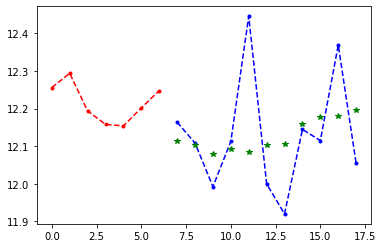

In [54]:
for x, y in val_data.take(1):
    i = [i for i in range(7)]
    ii = [7+i for i in range(11)]
    plt.plot(i,x[0],'.r--')
    plt.plot(ii[-50:],multi_step_model.predict(x)[0][-50:],'.b--')
    plt.plot(ii[-50:],Y[0][-50:],'g*')

### Predict data:

We will now use the data from the FCA2.xlsx file to validate the model

In [76]:
FCA2 = pd.read_excel("FCA2.xlsx")
FCA2.Date = pd.to_datetime(FCA2.Date, format= "%d/%m/%Y  %H:%M:%S")
df_predict = FCA2.loc[(FCA2.Date.dt.hour>=10)&(FCA2.Date.dt.hour<17)].\
    loc[(FCA2.Date.dt.day!=24)&(FCA2.Date.dt.day!=26)].\
    sort_values(by="Date", ascending=True).\
    reset_index(drop=True).rename({"Close(FCHA.MI)":"Price"}, axis='columns')
df_predict = df_predict.loc[df_predict.Date.dt.minute==0].copy()

In [56]:
X_predict = np.empty((df_predict.shape[0]-7, 7))
np.zeros((df_predict.shape[0]-7, 7))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
for row, i in enumerate(range(7,df_predict.shape[0])): 
    X_predict[row,:] = df_predict.iloc[(i-7):i,1].values

In [58]:
X_predict.shape

(392, 7)

In [59]:
#lets put it into a tensor shape
x_pred = np.reshape(X_predict, (392, 7,1))


In [60]:
y_pred = multi_step_model.predict(x_pred)

In [61]:
y_pred.shape

(392, 11)

### Export and plot

In [62]:
dateaxis = pd.Series(np.reshape(np.concatenate([pd.date_range(start=pd.Timestamp("{} 10:00:00".format(date)), \
               end=pd.Timestamp("{} 17:00:00".format(date)), freq='5min', ) for date in sorted(set(df_predict.Date.astype(str).str[:10]))[1:]]),-1))

In [63]:
df_output = pd.DataFrame({"Date":dateaxis[dateaxis.dt.minute != 0], "Prediction":np.reshape(y_pred, -1)})

In [64]:
df_output

,Date,Prediction
1,2019-12-30 10:05:00,12.135030
2,2019-12-30 10:10:00,12.102859
3,2019-12-30 10:15:00,12.001595
4,2019-12-30 10:20:00,12.113270
5,2019-12-30 10:25:00,12.390929
...,...,...
4754,2020-03-23 16:35:00,11.291602
4755,2020-03-23 16:40:00,11.727081
4756,2020-03-23 16:45:00,11.546262
4757,2020-03-23 16:50:00,12.002880


In [65]:
df_output.to_csv("predictions_tensorflow.csv", index=False)

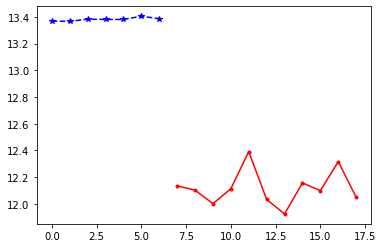

In [69]:


i = [i for i in range(7)]
ii = [7+i for i in range(11)]
plt.plot(i, x_pred[0], '*b--')
plt.plot(ii, y_pred[0], '.r-')